%%latex
\tableofcontents

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import torch
from torch import nn # pytorch neural networks
from torch.utils.data import Dataset, DataLoader # pytorch dataset structures
from torchvision.transforms import ToTensor # pytorch transformer
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor

# Introduction

The conserved variables are $(D, S_i, \tau)$ and they are related to primitive variables, $w = (\rho, v^i, \epsilon, p)$, defined in the local rest frame of the fluid through (in units of light speed $c = 1$). The P2C is explicitly given:
\begin{equation}
D = \rho W \, , \quad S_i = \rho h W^2 v_i \, , \quad \tau = \rho h W^2 - p - D \, ,
\end{equation}
where we used
\begin{equation}
W = (1 - v^2)^{-1/2} \, , \quad h = 1 + \epsilon + \frac{p}{\rho} \, .
\end{equation}

Our first goal is to reproduce the results from [this paper](https://www.mdpi.com/2073-8994/13/11/2157). We first focus on what they call __NNEOS__ networks. These are networks which are trained to infer information on the equation of state (EOS). In its simplest form, the EOS is the thermodynamical relation connecting the pressure to the fluid's rest-mass density and internal energy $p = \bar{p}(\rho, \epsilon)$. We consider an __analytical $\Gamma$-law EOS__ as a benchmark:
\begin{equation}
    p(\rho, \varepsilon) = (\Gamma - 1)\rho\epsilon \, ,
\end{equation}
and we fix $\Gamma = 5/3$ in order to fully mimic the situation of the paper.

# Generating training data

We generate training data for the NNEOS networks as follows. We create a training set by randomly sampling the EOS on a uniform distribution over $\rho \in (0, 10.1)$ and $\epsilon \in (0, 2.02)$. Below, we first focus on the implementation of __NNEOSB__ as called in the paper, meaning we also make the derivatives of the EOS part of the output. So we compute three quantities:
\begin{itemize}
\item $p$, using the EOS defined above
\item $\chi := \partial p/\partial\rho$, inferred from the EOS
\item $\kappa := \partial p/\partial \epsilon$, inferred from the EOS
\end{itemize}

In [2]:
# Define the three functions determining the output
def eos(rho, eps, Gamma = 5/3):
    """Computes the analytical gamma law EOS from rho and epsilon"""
    return (Gamma - 1) * rho * eps

def chi(rho, eps, Gamma = 5/3):
    """Computes dp/drho from EOS"""
    return (Gamma - 1) * eps

def kappa(rho, eps, Gamma = 5/3):
    """Computes dp/deps from EOS"""
    return (Gamma - 1) * rho

In [3]:
# Define ranges of parameters to be sampled (see paper Section 2.1)
rho_min = 0
rho_max = 10.1
eps_min = 0
eps_max = 2.02

Note: the code in comment below was used to generate the data. It has now been saved separately in a folder called "data".

In [4]:
number_of_datapoints = 10000 # 80 000 for train, 10 000 for test
data = []

for i in range(number_of_datapoints):
    rho = random.uniform(rho_min, rho_max)
    eps = random.uniform(eps_min, eps_max)
    
#     new_row = [rho, eps, eos(rho, eps), chi(rho, eps), kappa(rho, eps)]
    new_row = [rho, eps, eos(rho, eps)]
    
    data.append(new_row)

In [5]:
header = ['rho', 'eps', 'p', 'chi', 'kappa']

with open('NNEOSA_data_train.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    # write header
    writer.writerow(header)
    # write data
    writer.writerows(data)

In [6]:
# Import data
data_train = pd.read_csv("data/NNEOS_data_train.csv")
data_test = pd.read_csv("data/NNEOS_data_test.csv")
print("The training data has " + str(len(data_train)) + " instances")
print("The test data has " + str(len(data_test)) + " instances")
data_train

The training data has 80000 instances
The test data has 10000 instances


,rho,eps,p,chi,kappa
0,9.770794,0.809768,5.274717,0.539845,6.513863
1,10.093352,0.575342,3.871421,0.383561,6.728901
2,1.685186,1.647820,1.851255,1.098547,1.123457
3,1.167718,0.408377,0.317913,0.272251,0.778479
4,7.750848,1.069954,5.528700,0.713303,5.167232
...,...,...,...,...,...
79995,3.985951,1.642317,4.364131,1.094878,2.657301
79996,6.948815,0.809021,3.747824,0.539347,4.632543
79997,8.423227,1.125142,6.318217,0.750095,5.615485
79998,4.748173,0.774870,2.452810,0.516580,3.165449


In case we want to visualize the datapoints (not useful, nothing significant happening).

In [7]:
# rho = data_train['rho']
# eps = data_train['eps']

# plt.figure(figsize = (12,10))
# plt.plot(rho, eps, 'o', color = 'black', alpha = 0.005)
# plt.grid()
# plt.xlabel(r'$\rho$')
# plt.ylabel(r'$\epsilon$')
# plt.title('Training data')
# plt.show()

# Getting data into PyTorch's DataLoader

Below: all_data is of the type $(\rho, \epsilon, p, \chi, \kappa)$ as generated above.

In [8]:
class CustomDataset(Dataset):
    """See PyTorch tutorial: the following three methods HAVE to be implemented"""
    
    def __init__(self, all_data, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        # Separate features (rho and eps) from the labels (p, chi, kappa)
        # (see above to get how data is organized)
        features = []
        labels = []
        
        for i in range(len(all_data)):
            # Separate the features
            new_feature = [all_data['rho'][i], all_data['eps'][i]]
            features.append(torch.tensor(new_feature, dtype = torch.float32))
            # Separate the labels
            new_label = [all_data['p'][i], all_data['chi'][i], all_data['kappa'][i]]
            labels.append(torch.tensor(new_label, dtype = torch.float32))
            
        # Save as instance variables to the dataloader
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    # TODO: I don't understand transform and target_transform --- but this is not used now!
    def __getitem__(self, idx):
        feature = self.features[idx]
        if self.transform:
            feature = transform(feature)
        label = self.labels[idx]
        if self.target_transform:
            feature = target_transform(label)
            
        return feature, label

Note that the following cell may be confusing. "data_train" refers to the data that was generatd above, see the pandas table. "training_data" is defined similarly as in the PyTorch tutorial, see [this page](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and this is an instance of the class CustomDataset defined above.

In [9]:
# Make training and test data, as in the tutorial
training_data = CustomDataset(data_train)
test_data = CustomDataset(data_test)

In [10]:
# Check if this is done correctly
print(training_data.features[:2])
print(training_data.labels[:2])
print(training_data.__len__())
print(test_data.__len__())

[tensor([9.7708, 0.8098]), tensor([10.0934,  0.5753])]
[tensor([5.2747, 0.5398, 6.5139]), tensor([3.8714, 0.3836, 6.7289])]
80000
10000


In [11]:
# Now call DataLoader on the above CustomDataset instances:
train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

# Building the neural networks

We will follow [this part of the PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). For more information, see the [documentation page of torch.nn](https://pytorch.org/docs/stable/nn.html). We take the parameters of NNEOSB in the paper, see Table 1. __To do:__ check other activation functions and architectures.

In [12]:
# Define hyperparameters of the model here. Will first of all put two hidden layers
device = "cpu"
size_HL_1 = 400
size_HL_2 = 600

# Implement neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(2, size_HL_1),
            nn.Sigmoid(),
            nn.Linear(size_HL_1, size_HL_2),
            nn.ReLU(),
            nn.Linear(size_HL_2, 3)
        )

    def forward(self, x):
        # No flatten needed, as our input and output are 1D?
        #x = self.flatten(x) 
        logits = self.stack(x)
        return logits

# Training the neural network

Now we generate an instance of the above neural network in `model` (note: running this cell will create a 'fresh' model!).

Save hyperparameters and loss function - note that we follow the paper. I think that their loss function agrees with [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). The paper uses the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam). More details on optimizers can be found [here](https://pytorch.org/docs/stable/optim.html). Required argument `params` can be filled in by calling `model` which contains the neural network. For simplicity we will train for 10 epochs here. __Question:__ how many epochs should be used? What size for the batches,...

In [55]:
model = NeuralNetwork().to(device)
print(model)

# Save hyperparameters here --- see paper!!!
learning_rate = 6e-4
batch_size = 32
epochs = 200
# Initialize the loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
### not sure how this works
# Adaptive learning rate:  
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, verbose=True)

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=400, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=3, bias=True)
  )
)


The train and test loops are implemented below (copy pasted from [this part of the tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)):

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer, report_progress = False):
    """The training loop of the algorithm"""
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # If we want to report progress during training (not recommended - obstructs view)
        if report_progress:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    """The testing loop of the algorithm"""
    num_batches = len(dataloader)
    test_loss = 0

    # Predict and compute losses
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    average_test_loss = test_loss/num_batches
    return average_test_loss

In [57]:
def get_subset_train_dataloader(data_train, size = 10000):
    """Creates a 'subset' of dataloader for computing loss on training data.
        This way we can 'test' on training data too - to check the claim of the paper about overfitting. """
    
    # Get random ids to sample
    random_ids =  np.random.choice(len(data_train), size, replace=False)
    
    # the following is a pandas dataframe
    sampled_train_data = data_train.iloc[random_ids] 
    # relabel the indices
    sampled_train_data.index = [i for i in range(len(sampled_train_data))]
    new_dataset = CustomDataset(sampled_train_data)
    
    # Make it a dataloader and return it
    new_dataloader = DataLoader(new_dataset, batch_size=32)
    
    return new_dataloader

In [ ]:
# Restart training by changing this parameter:
restart = True
abort = False
update_lr = True
batch_size = 32
max_number_epochs = 500
adaptation_threshold = 0.9995
adaptation_multiplier = 0.5

# Initialize the loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists in case we start a new training loop
if restart:
    confirmation = input("Are you sure you want to restart? Press y >> ")
    if confirmation == "y":
        test_losses = []
        train_losses = []
        train_losses_subset = []
        adaptation_indices = []
        counter = -5 # we skip the very first few iterations before changing learning rate
    else:
        print("Aborting training.")
        abort = True

# Acutal training loop is done:
if abort is False:
    epoch_counter = len(train_losses) + 1

    print("Training the model . . .")
    if restart is False:
        print("(Continued)")
        
    # Training: 
    while epoch_counter < max_number_epochs:
        print(f"\n Epoch {epoch_counter} \n --------------")
        # Train 
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # Test on the training data
        average_train_loss = test_loop(train_dataloader, model, loss_fn)
        train_losses.append(average_train_loss)
        # Test on SUBSET of the training data
        train_subset_dataloader = get_subset_train_dataloader(data_train)
        average_train_loss = test_loop(train_subset_dataloader, model, loss_fn)
        train_losses_subset.append(average_train_loss)
        # Test on testing data
        average_test_loss = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(average_test_loss)

        # Update the learning rate - see Appendix B of the paper
        # only check if update needed after 10 new epochs
        if counter >= 10 and update_lr is True:
            current = np.min(train_losses[-5:])
            previous = np.min(train_losses[-10:-5])

            # If we did not improve the test loss sufficiently, going to adapt LR
            if current/previous >= adaptation_threshold:
                # Reset counter (note: will increment later, so set to -1 st it becomes 0)
                counter = -1
                learning_rate = adaptation_multiplier*learning_rate
                print(f"Adapting learning rate to {learning_rate}")
                # Change optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # Add the epoch time for plotting later on
                adaptation_indices.append(epoch_counter)

        # Report progress:
        print(f"Average loss of: {average_test_loss} for test data")
        print(f"Average loss of: {average_train_loss} for train data")
        
        # Another epoch passed - increment counter
        counter += 1
        epoch_counter += 1

    print("Done!")

Are you sure you want to restart? Press y >> y
Training the model . . .

 Epoch 1 
 --------------
Average loss of: 0.0005503342129954378 for test data
Average loss of: 0.0005130161922823001 for train data

 Epoch 2 
 --------------
Average loss of: 0.0010097285683531635 for test data
Average loss of: 0.001020742569694492 for train data

 Epoch 3 
 --------------
Average loss of: 0.0008193171563031622 for test data
Average loss of: 0.0008167845976967424 for train data

 Epoch 4 
 --------------
Average loss of: 0.000401173678941626 for test data
Average loss of: 0.00039291615456940766 for train data

 Epoch 5 
 --------------
Average loss of: 0.0004917982380934649 for test data
Average loss of: 0.0004822227072875245 for train data

 Epoch 6 
 --------------
Average loss of: 0.00028114452039988073 for test data
Average loss of: 0.0002801716965998853 for train data

 Epoch 7 
 --------------
Average loss of: 0.0002976945283307215 for test data
Average loss of: 0.0003017316720769785 for t

Average loss of: 2.0715819955628644e-05 for test data
Average loss of: 2.1344136498715415e-05 for train data

 Epoch 62 
 --------------
Average loss of: 2.02751393989835e-05 for test data
Average loss of: 2.084991608546389e-05 for train data

 Epoch 63 
 --------------
Average loss of: 2.056794048734411e-05 for test data
Average loss of: 2.0240689532518143e-05 for train data

 Epoch 64 
 --------------
Average loss of: 2.063912426076157e-05 for test data
Average loss of: 2.1593951432892796e-05 for train data

 Epoch 65 
 --------------
Average loss of: 2.0612357526586335e-05 for test data
Average loss of: 2.1149478036353883e-05 for train data

 Epoch 66 
 --------------
Average loss of: 2.32331421285633e-05 for test data
Average loss of: 2.4030285735229462e-05 for train data

 Epoch 67 
 --------------
Adapting learning rate to 7.5e-05
Average loss of: 2.4611028310320802e-05 for test data
Average loss of: 2.489472926492872e-05 for train data

 Epoch 68 
 --------------
Average loss of

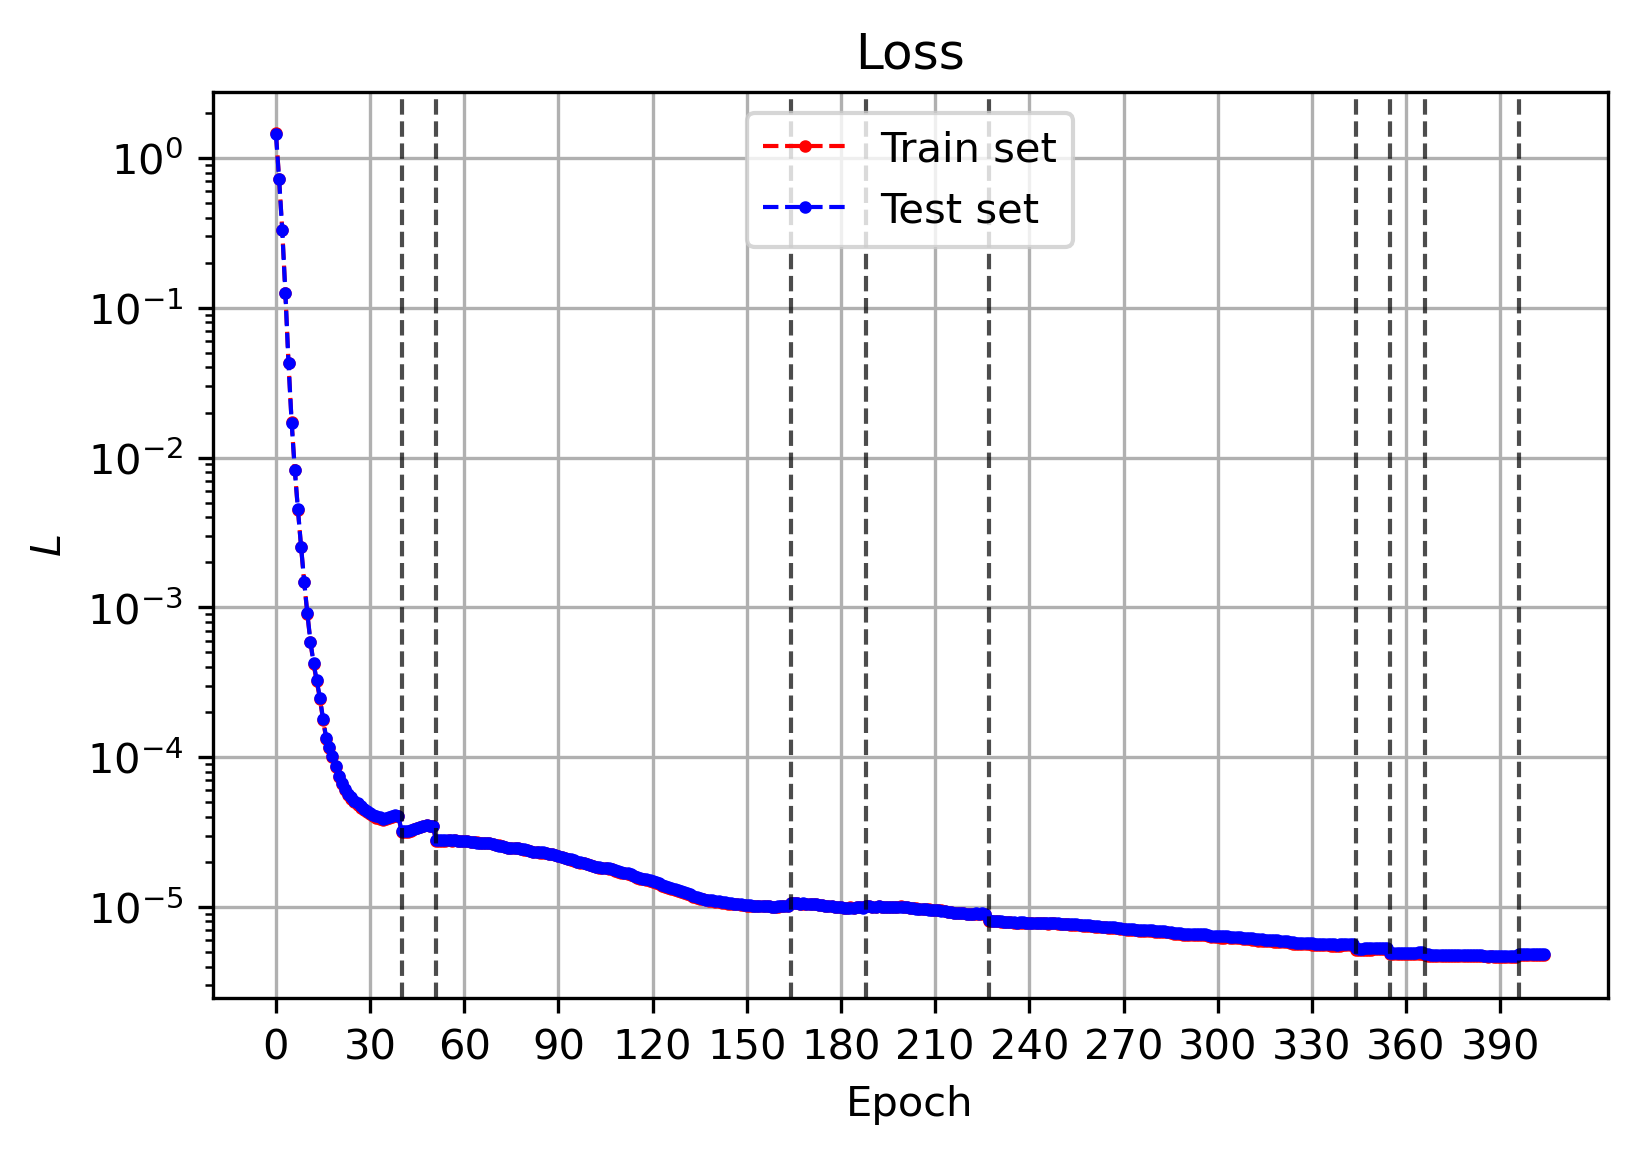

In [50]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(train_losses, 'o--', color = 'red', label = 'Train set', lw = lw, ms = ms)
plt.plot(test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 30
xt = [i*xt_step for i in range(len(train_losses)//xt_step+1)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Loss")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t, linestyle = "--", color = 'black', alpha = 0.7, lw = 1)
plt.yscale('log')
# plt.ylim(10**(-9))
# plt.savefig("Plots/trying_adaptive_lr.pdf", bbox_inches = 'tight')
plt.show()

## Results of training

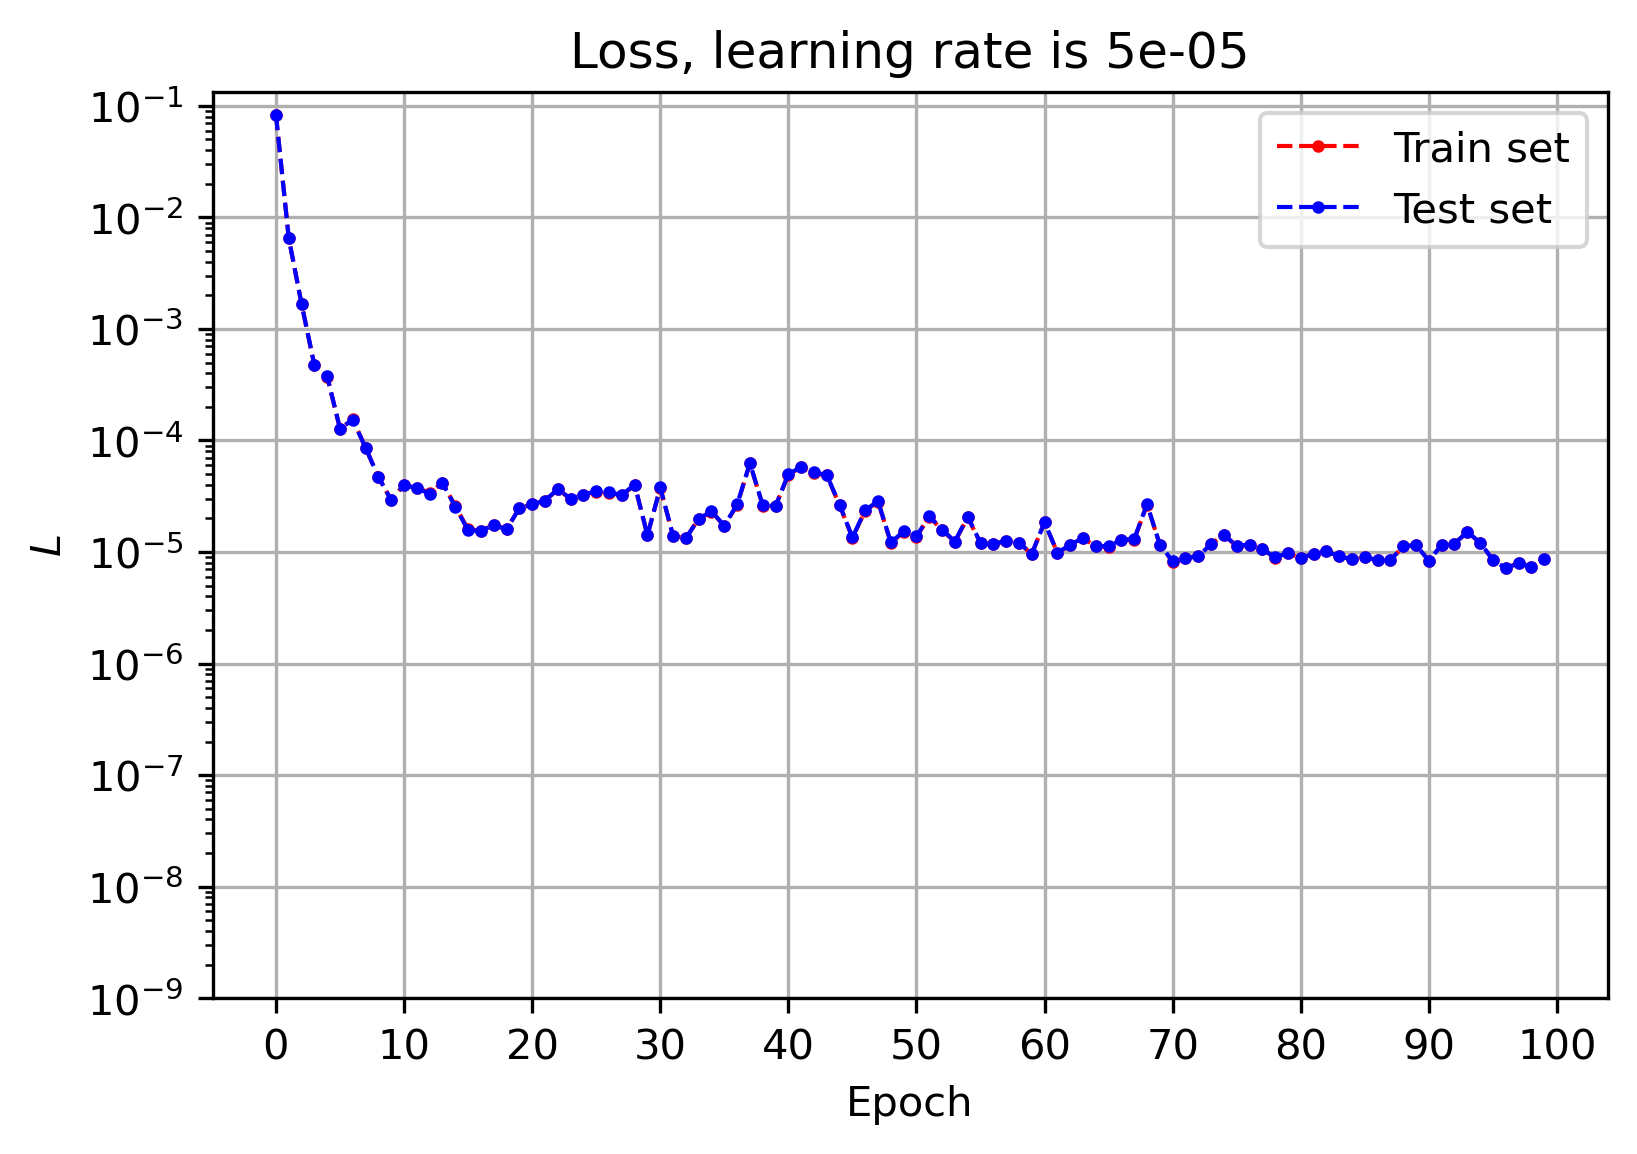

In [62]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(train_losses, 'o--', color = 'red', label = "Train set", lw = lw, ms = ms)
plt.plot(test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 10
xt = [i*xt_step for i in range(len(train_losses)//xt_step+1)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title(f"Loss, learning rate is {learning_rate}")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t, linestyle = "--", color = 'black', alpha = 0.7, lw = 1)
plt.yscale('log')
plt.ylim(10**(-9))
plt.savefig("Plots/example_no_adapting_lr_v2.pdf", bbox_inches = 'tight')
plt.show()

## Save the neural network

In [25]:
# torch.save(model, 'NNEOSBv0.pth')

Testing the loading of models

In [27]:
test = torch.load('NNEOSBv0.pth')

# Archive


The following plots the difference between the train and test loss. However, I put it in the archive of this notebook, as the differences are usually very small and hence unimportant for practical aspects.

In [ ]:
# Get the difference (need np.array)
test_losses_as_array = np.array(test_losses)
train_losses_as_array = np.array(train_losses)
difference = test_losses_as_array - train_losses_as_array

# Plot it
plt.figure()
plt.plot(difference[20:], 'o--', color = 'red', label = "Difference", lw = 1, ms = 1.5)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel(r'$L_{test} - L_{train}$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Difference in losses")
# Plot when we adapted learning rate
# for t in adaptation_indices:
#     plt.axvline(t, color = 'black', alpha = 0.7)
plt.show()

## Line search to find the optimal learning rate parameter

For now, we are __not__ using a self-adaptive algorithm, but rather, we are going to do a line search to find the optimal value for the learning rate using a log scale as recommended by the book of Goodfellow. 

In [63]:
lr_list = [10**(-3), 10**(-4), 10**(-5), 10**(-6), 10**(-7)]
all_train_losses = []
all_test_losses = []

# Hyperparameters:
batch_size = 32
max_number_epochs = 100

for learning_rate in lr_list:
    ## Do a run: for one single learning rate
    
    # Make a new model, empty train and test loss arrays again
    model = NeuralNetwork().to(device)
    test_losses = []
    train_losses = []
    
    # Initialize the loss function
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # ----- Train the model -----
    print(f"Training the model with lr {learning_rate} . . .")
    for t in range(max_number_epochs):
        print(f"\n Epoch {t+1} \n --------------")
        # Train 
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # Test on the training data
        average_train_loss = test_loop(train_dataloader, model, loss_fn)
        train_losses.append(average_train_loss)
        # Test on testing data
        average_test_loss = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(average_test_loss)
        
    # ----- Train the model -----
    print('Finished a run')
    all_test_losses.append(test_losses)
    all_train_losses.append(train_losses)

    print("Done!")

Training the model with lr 0.001 . . .

 Epoch 1 
 --------------

 Epoch 2 
 --------------

 Epoch 3 
 --------------

 Epoch 4 
 --------------

 Epoch 5 
 --------------

 Epoch 6 
 --------------

 Epoch 7 
 --------------

 Epoch 8 
 --------------

 Epoch 9 
 --------------

 Epoch 10 
 --------------

 Epoch 11 
 --------------

 Epoch 12 
 --------------

 Epoch 13 
 --------------

 Epoch 14 
 --------------

 Epoch 15 
 --------------

 Epoch 16 
 --------------

 Epoch 17 
 --------------

 Epoch 18 
 --------------

 Epoch 19 
 --------------

 Epoch 20 
 --------------

 Epoch 21 
 --------------

 Epoch 22 
 --------------

 Epoch 23 
 --------------

 Epoch 24 
 --------------

 Epoch 25 
 --------------

 Epoch 26 
 --------------

 Epoch 27 
 --------------

 Epoch 28 
 --------------

 Epoch 29 
 --------------

 Epoch 30 
 --------------

 Epoch 31 
 --------------

 Epoch 32 
 --------------

 Epoch 33 
 --------------

 Epoch 34 
 --------------

 Epoch 35 
 -----


 Epoch 89 
 --------------

 Epoch 90 
 --------------

 Epoch 91 
 --------------

 Epoch 92 
 --------------

 Epoch 93 
 --------------

 Epoch 94 
 --------------

 Epoch 95 
 --------------

 Epoch 96 
 --------------

 Epoch 97 
 --------------

 Epoch 98 
 --------------

 Epoch 99 
 --------------

 Epoch 100 
 --------------
Finished a run
Done!
Training the model with lr 1e-06 . . .

 Epoch 1 
 --------------

 Epoch 2 
 --------------

 Epoch 3 
 --------------

 Epoch 4 
 --------------

 Epoch 5 
 --------------

 Epoch 6 
 --------------

 Epoch 7 
 --------------

 Epoch 8 
 --------------

 Epoch 9 
 --------------

 Epoch 10 
 --------------

 Epoch 11 
 --------------

 Epoch 12 
 --------------

 Epoch 13 
 --------------

 Epoch 14 
 --------------

 Epoch 15 
 --------------

 Epoch 16 
 --------------

 Epoch 17 
 --------------

 Epoch 18 
 --------------

 Epoch 19 
 --------------

 Epoch 20 
 --------------

 Epoch 21 
 --------------

 Epoch 22 
 -----------